In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

import japanize_matplotlib
from fractions import Fraction

## 理想的な回路作成


In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

### 動作の確認
5量子ビットのアルゴリズムを実装し、動作を確認する。

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]
adf:(1+0j)


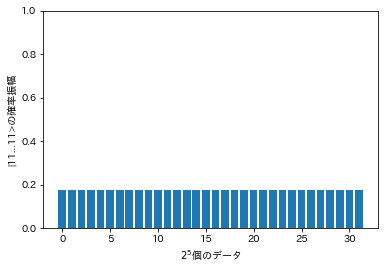

初期：[0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j]


In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()
print(state.get_vector())
print(f'adf:{state.get_vector()[0]}')
# state.set_random_state()
# print(state.get_vector())

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)
print(f'初期：{state.get_vector()}')



In [4]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [5]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

In [6]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


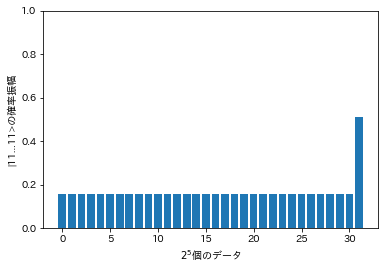

In [7]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

In [8]:
nqubits = 5

# グローバーのアルゴリズム
def grover(nqubits, operate_time):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


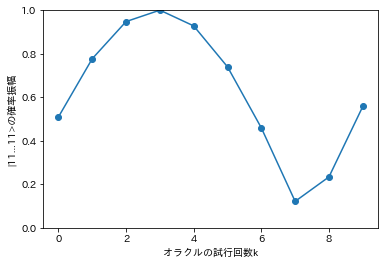

In [9]:
grover(5, 10)

## ランダムな初期状態の作成
次に、ランダムな初期状態を作成する。

In [10]:
# 量子状態と複素数の積を利用して計算

nqubits = 5
p = 0.5
state1 = QuantumState(nqubits)
state2 = QuantumState(nqubits)
state1.set_zero_state()
state2.set_zero_state()
# psi_0, psi_Haar = state
psi_0 = state1
psi_Haar = state2

Hadamard = make_Hadamard(nqubits)
# Hadamard.update_quantum_state(psi_0)
psi_0.set_zero_state()

psi_Haar.set_Haar_random_state()

# print(f'psi_0s norm: {psi_0.get_squared_norm()}, psi_Haars norm:{psi_Haar.get_squared_norm()}')
# (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
coef = np.sqrt(1 - p)
psi_0.multiply_coef(coef)
print(f'psi_0:{psi_0.get_squared_norm()}')

coef = np.sqrt(p)
psi_Haar.multiply_coef(coef)
print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

# (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
state = psi_0
state.add_state(psi_Haar)
print(f'state:{state.get_vector()}')
print(f'ノルム：{state.get_squared_norm()}')
print(state.get_qubit_count())

psi_0:0.5000000000000001
psi_Haar: 0.49999999999999994
state:[ 0.80759468-0.03668496j -0.07183992+0.00610535j  0.15197116+0.01080154j
  0.01991045-0.06404376j -0.02134819-0.00591066j  0.10817722+0.15187133j
 -0.15970638-0.03360746j  0.08359709-0.12374562j  0.19321419+0.00120384j
  0.00557928-0.02853893j  0.10235096-0.01523873j  0.11933205-0.07031204j
  0.01680214-0.18358109j  0.03922504+0.00832662j -0.01406495+0.0878711j
  0.19639966+0.06521834j -0.00954479-0.01755022j -0.04580588+0.05573161j
  0.06121535+0.05795463j  0.00969537+0.06538911j  0.11742799+0.16703953j
 -0.0258629 -0.02389096j  0.05148878-0.00193462j -0.09612553-0.15067069j
 -0.03681436+0.15023539j  0.0096225 -0.02430045j  0.05226827-0.14815213j
  0.05142329+0.01485523j -0.04325496-0.05190994j -0.08687177+0.08845476j
  0.03553614+0.01556612j -0.12543404+0.18195473j]
ノルム：1.1421113532440739
5


In [11]:
from qulacs import QuantumState
from qulacs.state import permutate_qubit, drop_qubit

In [12]:
def noisy_grover(nqubits, operate_time, dephasing_rate):
    # state = QuantumState(nqubits)
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    # psi_0, psi_Haar = state
    psi_0 = state1
    psi_Haar = state2

    # Hadamard = make_Hadamard(nqubits)
    # Hadamard.update_quantum_state(psi_0)
    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # print(f'psi_0s norm: {psi_0.get_squared_norm()}, psi_Haars norm:{psi_Haar.get_squared_norm()}')
    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    # state = QuantumState(nqubits)
    # state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")


In [13]:
def noisy_grover_graph_output(nqubits, operate_time, dephasing_rate):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")

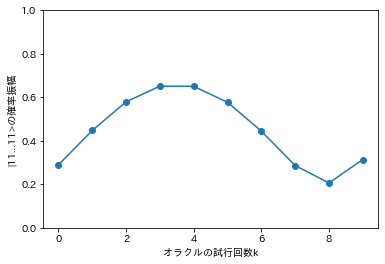

In [14]:
max_result_k = []
noisy_grover(5, 10, 0.5)

### 確率の変更
確率pが0〜10まででどうのような動きをするのか調べる

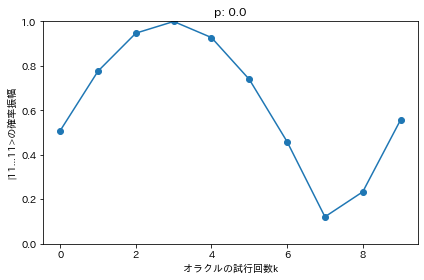

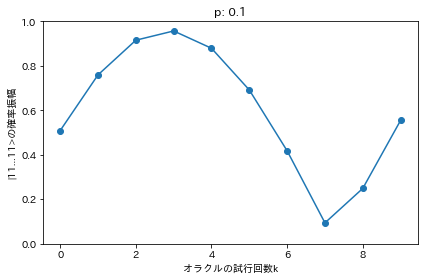

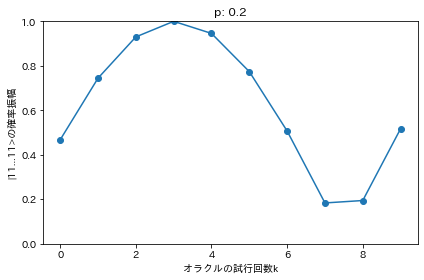

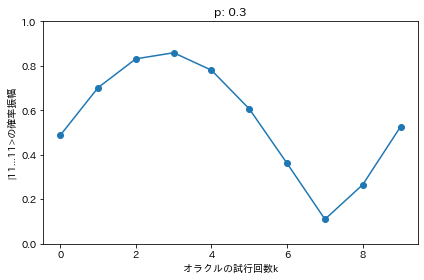

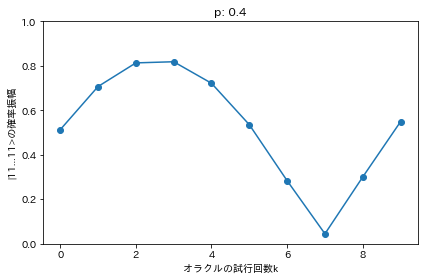

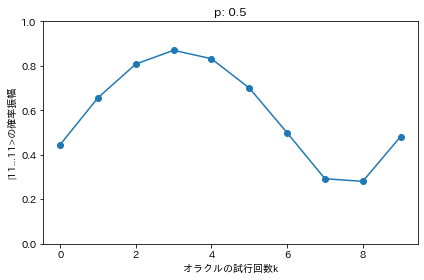

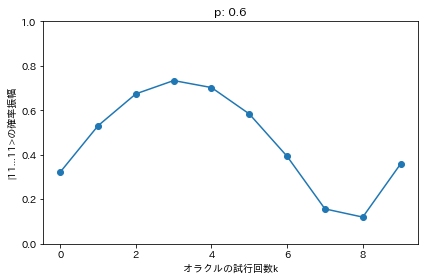

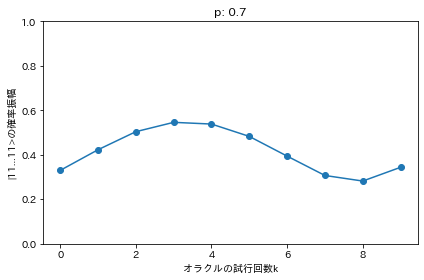

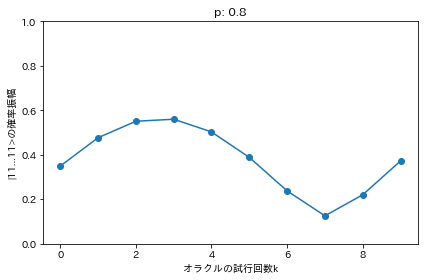

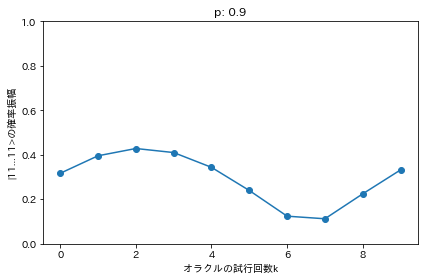

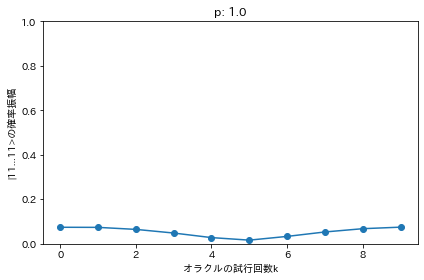

In [15]:
max_result_k = []
p = 10
for i in range(p + 1):
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'p: {i / 10}')

    noisy_grover(5, 10, i / 10)
    # noisy_grover(5, 10)

## 最大値に注目する(kに注目する)

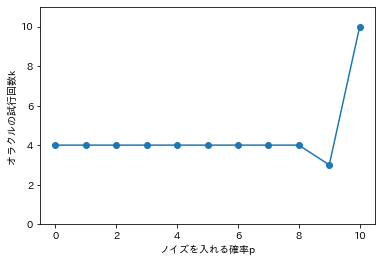

In [16]:
plt.plot(max_result_k, "-o")
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.ylim(0, np.max(max_result_k) + 1)
plt.show()

 サンプルを増やして、グラフ化してみる

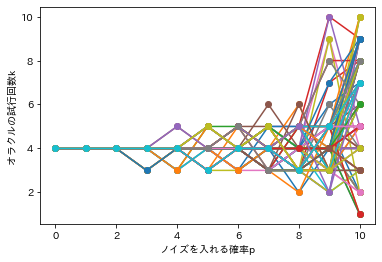

In [17]:
max_result = []
nqubits = 5

for i in range(100):
    max_result_k = []
    for j in range(p + 1):
        noisy_grover_graph_output(nqubits, 10, j / 10)
    max_result.append(max_result_k)

# print(max_result)
for i in max_result:
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('オラクルの試行回数k')
    plt.plot(i, "-o")

In [18]:
hoge = []
for i in range(p + 1):
    fuga = []
    for j in range(100):
        fuga.append(max_result[j][i])
    hoge.append(fuga)


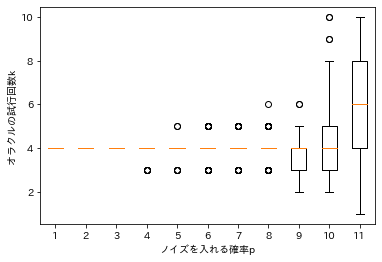

In [19]:

plt.boxplot(hoge)
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.show()

分散：0.0
分散：0.0
分散：0.0
分散：0.056400000000000006
分散：0.06909999999999998
分散：0.20989999999999998
分散：0.1899
分散：0.41639999999999994
分散：0.6074999999999998
分散：2.3571
分散：6.533900000000001


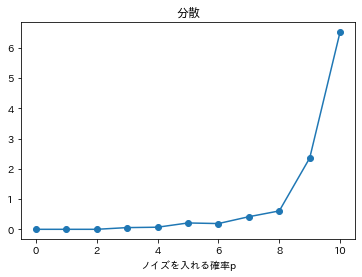

In [20]:
# 分散
var_array = []
for i in range(p + 1):
    v = np.var(hoge[i])
    var_array.append(v)
    print(f'分散：{v}')

plt.plot(var_array, "-o")
plt.title("分散")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

標準偏差:0.0
標準偏差:0.0
標準偏差:0.0
標準偏差:0.23748684174075835
標準偏差:0.26286878856189827
標準偏差:0.45814844755821227
標準偏差:0.43577517139001853
標準偏差:0.6452906321960671
標準偏差:0.7794228634059946
標準偏差:1.5352849898308782
標準偏差:2.556149447900103


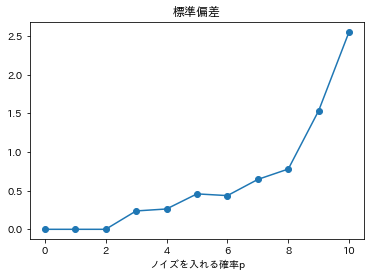

In [21]:
# 標準偏差
std_array = []

for i in range(p + 1):
    std = np.std(hoge[i])
    std_array.append(std)
    print(f'標準偏差:{std}')

plt.plot(std_array, "-o")
plt.title("標準偏差")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

## k = 4の時に注目する

In [22]:
k_array = []
def noisy_grover_graph_output_k(nqubits, operate_time, dephasing_rate, k):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    # max_k = np.argmax(result)
    k_array.append(result[3])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")


In [23]:
nqubits = 5
k = 4
k_array = []
for i in range(p + 1):
    noisy_grover_graph_output_k(nqubits, 10, i / 10, k)

print(k_array)

[0.9995910741614723, 0.9536971533664548, 0.801167178237273, 0.8923459615733512, 0.7759646248266119, 0.6163790080977429, 0.8697666917566096, 0.694978385359395, 0.42169067311123115, 0.27404359294954644, 0.16644701680919577]


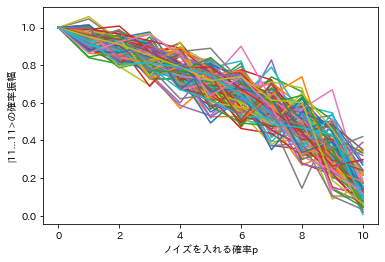

In [24]:
max_result = []
nqubits = 5
k = 4

for i in range(100):
    k_array = []
    for j in range(p + 1):
        noisy_grover_graph_output_k(nqubits, 10, j / 10, k)
    max_result.append(k_array)

# print(max_result)
for i in max_result:
    plt.plot(i)
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('|11...11>の確率振幅')

